In [1]:
import vaex
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from scipy.stats import poisson
from os.path import join, abspath
import sys
from os import pardir
from tqdm import tqdm

In [2]:
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/3_Vertical_Velocity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import safe_mkdir, style

style()

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [6]:
name = "metal"
spectral_dir = join(root_data_dir, "Cluster", name)
spectral_dir

'/home2/s20321005/Thesis-Project/Data/Cluster/metal'

In [7]:
vel_dir = join(root_data_dir, "Velocity-Distribution")
safe_mkdir(vel_dir)
vel_dir = join(root_data_dir, "Velocity-Distribution", name)
safe_mkdir(vel_dir)

Directory /home2/s20321005/Thesis-Project/Data/Velocity-Distribution already exist. Good to go!
Directory /home2/s20321005/Thesis-Project/Data/Velocity-Distribution/metal already exist. Good to go!


In [8]:
files = glob(join(spectral_dir, "gaia*.hdf5"))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/Cluster/metal/gaia_(-0.00)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Cluster/metal/gaia_(0.14)_(0.33).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Cluster/metal/gaia_(0.33)_(0.37).hdf5']

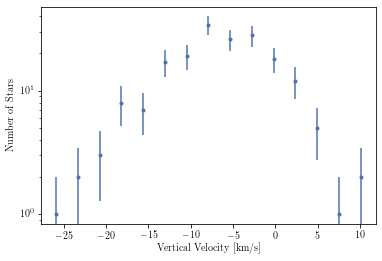

100%|██████████| 50000/50000 [00:02<00:00, 17742.74it/s]


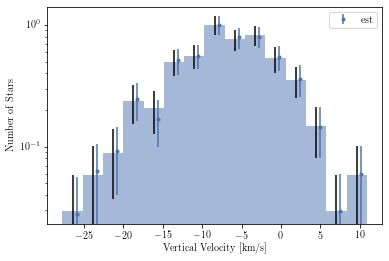

export(hdf5) [########################################] 100.00% elapsed time  :     0.02s =  0.0m =  0.0h
 saved w_(-0.00)_(0.14).hdf5


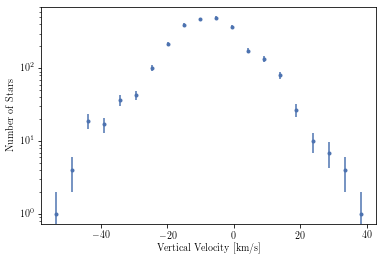

100%|██████████| 50000/50000 [00:15<00:00, 3304.20it/s]


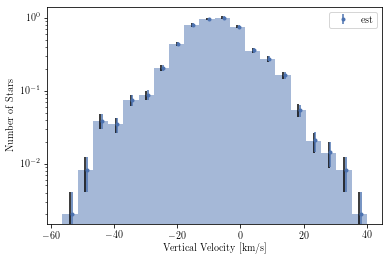

export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 saved w_(0.14)_(0.33).hdf5


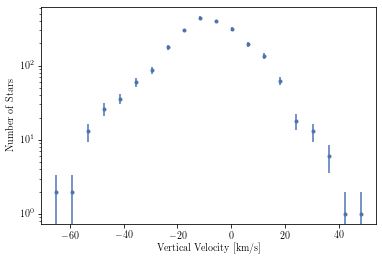

100%|██████████| 50000/50000 [00:14<00:00, 3333.89it/s]


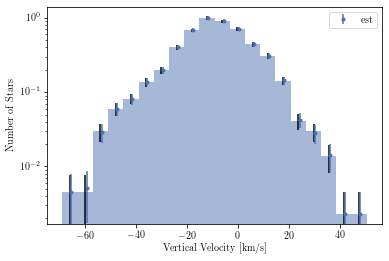

export(hdf5) [########################################] 100.00% elapsed time  :     0.04s =  0.0m =  0.0h
 saved w_(0.33)_(0.37).hdf5


In [9]:
from scipy.special import gamma
from scipy.stats import norm
from scipy.optimize import curve_fit
from hammer import vertical

def p_approx(x, n):
    if n > 100:
        return norm.pdf(x, n, np.sqrt(n))
    return np.power(x, n)*np.exp(-x)/gamma(n+1)

for file in files:
    gaia = vaex.open(file)
    gaia = gaia.filter("abs(z)<50").filter("rv>-999")
    gaia = gaia.extract()
    ws = gaia['w'].to_numpy()
    ews = gaia['e_w'].to_numpy()
    p = gaia['parallax'].to_numpy()/1000
    e_p = gaia['e_parallax'].to_numpy()/1000
    vr = gaia['rv'].to_numpy()
    e_vr = gaia['rv_el'].to_numpy()
    mub = gaia['pmlat'].to_numpy()/1000
    e_mub = gaia['e_pmlat'].to_numpy()/1000
    b = gaia['GLAT'].to_numpy()
    mask = ~np.isnan(ws) & ~np.isnan(ews)
    ws = ws[mask]
    ews = ews[mask]

    med = np.median(ws)
    mad = np.median(np.abs(ws-med))
    BIN = 20
    wedge = np.linspace(med-mad*7, med+mad*7, BIN+1)

    wmid = (wedge[1:] + wedge[:-1]) / 2
    wnum, _ = np.histogram(ws, wedge)
    # mask = (wnum == 0) | ((wmid < -30) & (wmid > -45)) | (wmid < -70)
    mask = (wnum == 0)
    wnum = wnum[~mask]
    wmid = wmid[~mask]
    werr = np.sqrt(wnum)
    max = np.max(wnum)
    
    plt.errorbar(wmid, wnum, yerr=werr, fmt='.')
    plt.xlabel("Vertical Velocity [km/s]")
    plt.ylabel("Number of Stars")
    plt.yscale('log')
    plt.show()
    # continue
    # break
    M = 50_000
    # log_w = np.empty(M, dtype=float)
    wnum_est = np.empty((M, len(wmid)), dtype=int)
    n = len(ws)
    mub_realizations = np.random.normal(loc=np.repeat(mub, M), scale=np.repeat(e_mub, M), size=n*M)
    mub_realizations = mub_realizations.reshape((n, M)).transpose()
    vr_realizations = np.random.normal(loc=np.repeat(vr, M), scale=np.repeat(e_vr, M), size=n*M)
    vr_realizations = vr_realizations.reshape((n, M)).transpose()
    r_realizations = vertical.generate_z(p, e_p, np.repeat(np.pi/2, n), n=M)
    # for i, (mub_realization, vr_realization, r_realization) in enumerate(zip(mub_realizations.transpose(), vr_realizations.transpose(), r_realizations)):
    for i, (mub_realization, vr_realization, r_realization) in enumerate(zip(tqdm(mub_realizations), vr_realizations, r_realizations)):
        # print(r_realization.shape)
        w_realization = 4.74 * r_realization * mub_realization*np.cos(b) + vr_realization*np.sin(b)
        wnum_est_i = np.histogram(w_realization, bins=wedge)[0]
        wnum_est[i] = wnum_est_i[~mask]
    west = np.empty_like(wnum, dtype=float)
    for i in range(len(wmid)):
        wnum_est_min = np.floor(wnum_est[:, i].min())
        wnum_est_max = np.ceil(wnum_est[:, i].max())
        bins = np.arange(wnum_est_min-1/2, wnum_est_max+1)
        weight, wn_edge = np.histogram(wnum_est[:, i], bins=bins, density=True)

        wn_mid = (wn_edge[1:] + wn_edge[:-1]) / 2
        mask = weight > 0
        weight = weight[mask]
        wn_mid = wn_mid[mask]
        m = 6
        # plt.bar(wn_mid, weight, width=1, alpha=0.5)
        west_x = np.linspace(np.maximum(0, np.floor(wnum[i]-m*werr[i])), np.floor(wnum[i]+m*werr[i]), 1_000)
        dw = west_x[1] - west_x[0]
        pn = np.sum(weight[:, None]*poisson.pmf(wn_mid[:,None], west_x[None, :]), axis=0)
        area = np.trapz(pn, west_x)
        pn = pn / area
        popt_g, _ = curve_fit(p_approx, west_x, pn, p0=[wnum[i]])
        popt_n, _ = curve_fit(norm.pdf, west_x, pn, p0=[wnum[i], np.sqrt(wnum[i])])
        west[i] = popt_g[0]
        # fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        # ax[0].bar(wn_mid, weight, width=1, alpha=0.5, edgecolor='k')
        # ax[0].set_xlabel(r"$N_i$")
        # ax[0].set_ylabel(r"$W(N_i)$")
        # ax[1].plot(west_x, pn, c='C0', lw=2)
        # ax[1].plot(west_x, p_approx(west_x, *popt_g), label='gamma', ls="--", c='r')
        # ax[1].plot(west_x, norm.pdf(west_x, *popt_n), label='normal', ls="--", c='g')
        # # ax[1].axvline(wnum[i], c='C3', ls='--', label='asli')
        # ax[1].set_xlabel(r"$\Lambda$")
        # ax[1].set_ylabel(r"$p(\Lambda)$")
        # ax[1].set_ylim(0)
        # ax[1].set_xlim(west_x.min(), west_x.max())
        # ax[1].legend()
        # # fig.savefig(join("img", f"histogram-approx-1.pdf"), dpi=70)
        # plt.show()
    #     break
    # break
    dw = np.min(np.diff(wedge))
    plt.bar(wmid-0.5, wnum/wnum.max(), yerr=werr/wnum.max(), width=dw, alpha=0.5)
    plt.errorbar(wmid, west/west.max(), yerr=np.sqrt(west)/west.max(), fmt='.', label="est")
    plt.xlabel("Vertical Velocity [km/s]")
    plt.ylabel("Number of Stars")
    plt.legend()
    plt.yscale('log')
    plt.show()
    
    name = file.split("/")[-1].replace("gaia", "w")
    df = vaex.from_arrays(mid=wmid, num=west)

    df.export(join(vel_dir, name), progress=True)
    print("saved", name) 
    # break